# THIS NOTEBOOK IS FOCUSING ON RED BAND NOW, ITL sensor, R02_S21

In [1]:
import glob
import os
from lsst import afw
#print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL, internaladjustment
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-5-gac0d578b1+6c871ee35c


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]
[619.997 624.979]
[0.94363887 0.95255824]
[0.00000000e+000 0.00000000e+000 6.02562418e-277 1.30739184e-228
 1.21148028e-184 7.11944804e-146 3.02382453e-111 1.08944657e-081
 1.52397759e-056 3.94966546e-036 2.74339844e-020 3.89408303e-009
 1.25588740e-002 9.43638875e-001 9.52558239e-001 1.61231863e-003
 6.20880101e-011 5.28099940e-023 1.04766134e-039 4.59087746e-061
 5.43700854e-087 1.55385810e-117 7.36116708e-153 6.05725044e-193
 1.00906785e-227 1.60551096e-237 1.05105196e-286 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

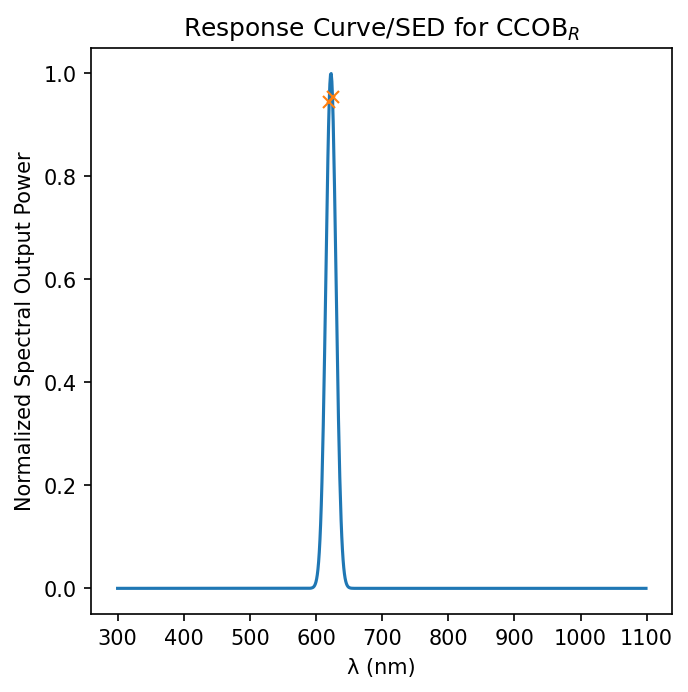

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

wls_copy = wls.copy()
two_wls = wls_copy[13:15]
print(two_wls)

# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)

# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(two_wls, x, y)  
weights_orig = numpy.interp(wls, x, y)
print(weights)
print(weights_orig)

# plots 'x's
pylab.plot(two_wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

## TRYING SOMETHING NEW TO MAKE COMBINED AND FIX PARALLEL STRUCTURE GRADIENT IN RATIOS ####

In [3]:
## Using only 2 wavelengths from the ts8 QE data files to make the "weights" function, whi

In [4]:
#### TRYING SOMETHING NEW TO MAKE COMBINED AND FIX PARALLEL STRUCTURE GRADIENT IN RATIOS ####

def create_combined_ITL(superdarkpath, superbiaspath, qeflatpath, weights, title):    
    superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
    superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias
    
    num_ch = 16
    img_list = []
    MEDIAN = None

    # loops over each amplifier in the CCD
    for ch in range(num_ch):
        arr = []                # defines an empty array for storing new combined flat for each amplifier
        for i, aqeflatpath in enumerate(qeflatpath):
            aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)

            img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array

            MEDIAN = numpy.median(img)
            img = img/MEDIAN     # this will normalize your image

            arr.append(img*numpy.mean(weights))

        img = numpy.sum(arr,axis=0)/numpy.mean(weights)   # NEED THIS LINE TO MAKE COMBINED IN R BAND (weights function called)
        std = mad_std(img)
        # puts images into a list to use below
        img_list.append(img)  
        
    plotonesensor_ITL(img_list, title)
    return img_list
print()

In [5]:
def create_ccob(img_list):
    num_ch = 16
    red_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R02_S21_red_-211.815_-0.395.fits"  
    ccob_red = get_ccd_from_id(None, fname, [])
    
    for ch in range(num_ch):    
        red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]    # QE data array
        MEDIAN = numpy.median(red)                                        # median (not mean, avoiding outliers) of QE data array for CCOBred, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        red_arr[ch] = red 
    return normedimg_arr, red_arr

[1.         0.99988198 0.99872674 0.99971659 0.99944165 1.00025659
 1.00035341 1.00062292 1.00374361 1.00448655 1.00432622 1.00477028
 1.00404981 1.00464803 1.00517727 1.00601222]
[1.         0.99988198 0.99872674 0.99971659 0.99944165 1.00025659
 1.00035341 1.00062292 0.99406521 0.99480099 0.9946422  0.99508198
 0.99436846 0.99496091 0.99548504 0.99631194]


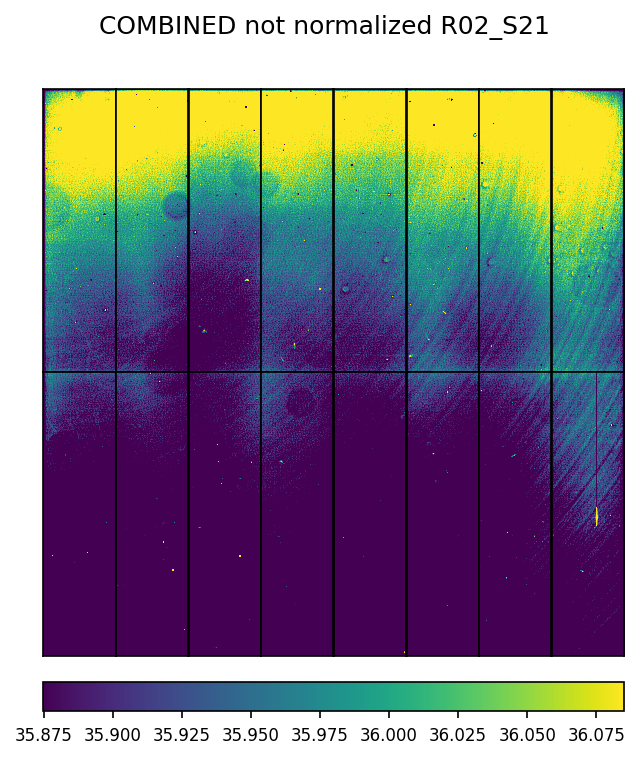

In [6]:
### GOAL: show combined flat for full sensor (all amplifiers) from ts8-stand narrowband QE flats weighted and summed to make combined ###

title = "COMBINED not normalized R02_S21"
img_list = create_combined_ITL(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
create_ccob(img_list)   # calling this function creates the combined flat, displays it, returns the img_list with combined data arrays, and creates data array lists for CCOB and combined normalized against CCOB
print('')

# Let's see how the Combined flat for FULL CCD SENSOR looks
# creating a broadband flat (Combined) from summed up narrow band flats weighted by QE response to RED wavelength

16
[1.         0.9987607  0.9948075  0.99711823 0.99584875 0.99839363
 0.9963664  0.99598275 1.00388426 1.00851701 1.00341336 1.00260978
 1.00282671 1.00232748 1.00189374 1.00139898]
[1.         0.9987607  0.9948075  0.99711823 0.99584875 0.99839363
 0.9963664  0.99598275 0.99420456 0.99879265 0.9937382  0.99294237
 0.99315721 0.9926628  0.99223324 0.99174325]


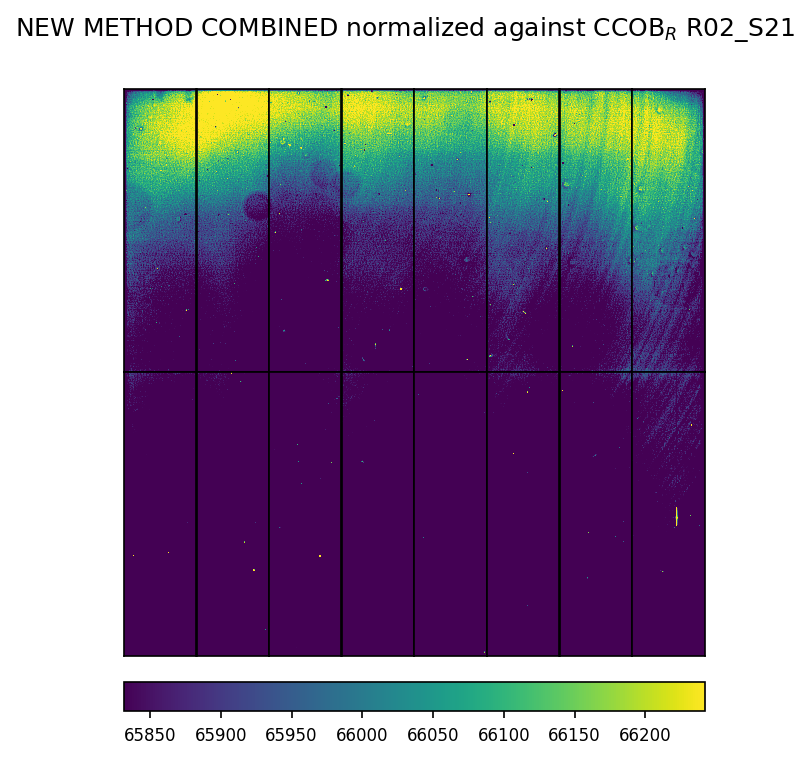

[1.         0.9987607  0.9948075  0.99711823 0.99584875 0.99839363
 0.9963664  0.99598275 1.00388426 1.00851701 1.00341336 1.00260978
 1.00282671 1.00232748 1.00189374 1.00139898]
[1.         0.99975765 0.99700226 0.99961224 0.99946109 1.00210611
 1.00000444 0.99891802 1.00905509 1.01372362 1.00907742 1.00877254
 1.01057925 1.01062527 1.01044203 1.0086887 ]
[1.         0.99975765 0.99700226 0.99961224 0.99946109 1.00210611
 1.00000444 0.99891802 1.00104133 1.00567278 1.00106348 1.00076103
 1.00255339 1.00259904 1.00241726 1.00067785]


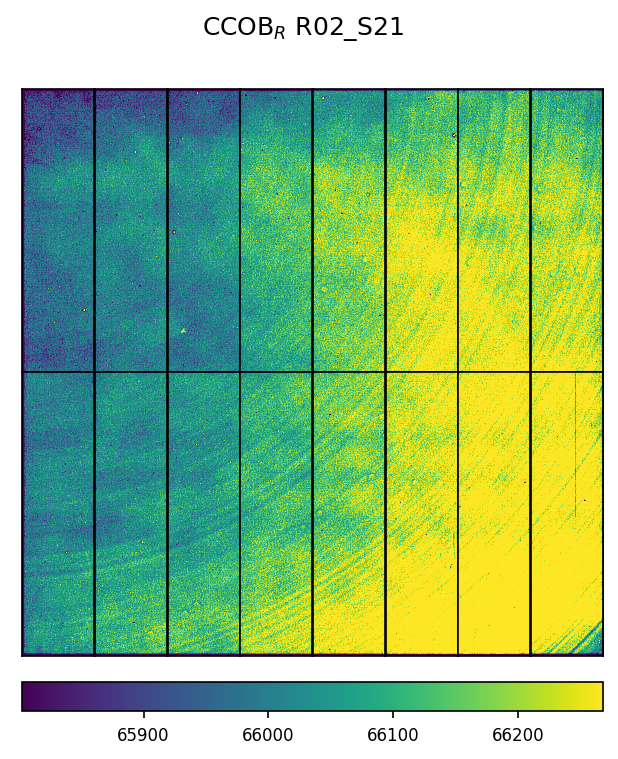

[1.         0.99975765 0.99700226 0.99961224 0.99946109 1.00210611
 1.00000444 0.99891802 1.00905509 1.01372362 1.00907742 1.00877254
 1.01057925 1.01062527 1.01044203 1.0086887 ]
[1.         0.99900281 0.99779864 0.99750502 0.99638571 0.99629532
 0.99636197 0.99706155 0.99317034 0.99315867 0.9926825  0.99218729
 0.99062775 0.99008951 0.98984054 0.99107145]


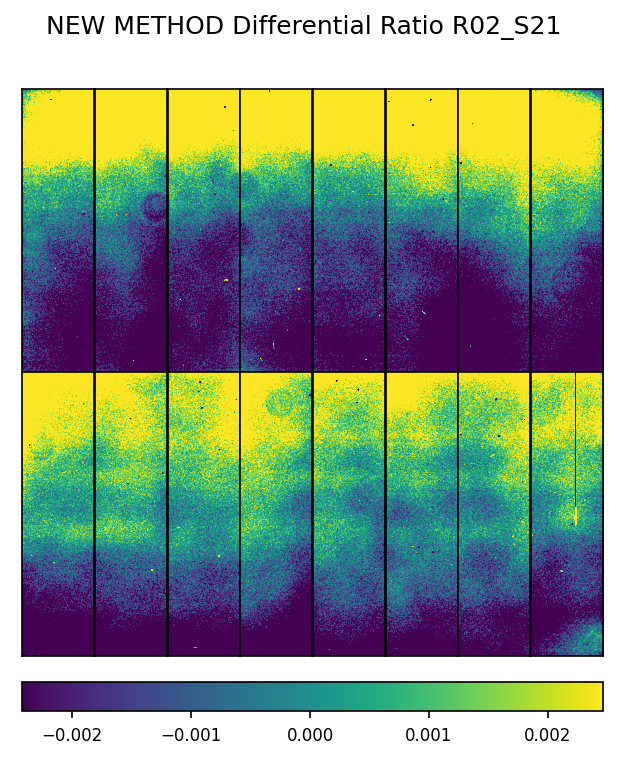

In [10]:
num_ch = 16
raft = 'R02'
filter_band = 'R'

normedimg_arr, red_arr = create_ccob(img_list)  

print(len(img_list))
image_com = plotonesensor_ITL(normedimg_arr, 'NEW METHOD COMBINED normalized against CCOB$_{R}$ ' + str(raft) + '_S21')
com_relnorm = internaladjustment(image_com)

image_com = plotonesensor_ITL(red_arr, 'CCOB$_{R}$ ' + str(raft) + '_S21')
ccob_relnorm = internaladjustment(image_com)

relnorm = com_relnorm/ccob_relnorm


diff_arr = [None] * num_ch
for ch in range(num_ch):
    diff_arr[ch] = (normedimg_arr[ch] - red_arr[ch]) / red_arr[ch]
plotonesensor_ITL(diff_arr, 'NEW METHOD Differential Ratio R02_S21', relativenorm=relnorm)
print()

## DISPLAYING A PLOT OF HISTOGRAMS OF QE VARIATION/PIXEL FOR EACH AMP IN SENSOR